# VLA Ephemeris object imaging (Callisto) : continuum (mosaic gridder)

This nootebook demonstlates continuum imaging of the ephemeris objects. 
In the following steps first we use the attached ephemeris table(s) 

In [2]:
# extra packages needed
#import os
#os.system('pip install astropy')
#os.system('pip install aplpy')

In [3]:
# import helper functions defined in 'Trackfield' mfs mosaic notebook
from ipynb.fs.defs.ephemimagingVenusMfsMosaicTrackfield import *

In [4]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat
from casatools import measures, quanta, table, image, msmetadata
import os
from astropy.io import fits
from matplotlib import pyplot
import pylab as pl
import aplpy
import shutil
me = measures()
qa = quanta()
tb = table()
ia = image()
msmd = msmetadata()

## Imaging with externally generated epehemeris data 
In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available. Alternatively, one can supply an updated ephemeris table generated by getephemtable task.

In [5]:
datapath='/stash/users/ttsutsum/casadev/imagingissues/ephemimaging/vladata/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [6]:
msfile='callisto_ka_leading_polcal_averagespw.ms'
msfile=datapath+msfile
# to make a local copy
#if os.path.exists(msfile):
#    shutil.rmtree(msfile)
#os.system(f'cp -r {datapath}{msfile} {msfile}')

In [7]:
imgname='mosaic-mfs-trackfield-callisto-vla-exttab'

In [8]:
delete_tcleanimages(imgname)

Determine timerange and interval from the internal ephemeris table

In [14]:
# Use the same interval as the attached ephemeris table 
# find path to the internal table
inephemtab = get_attachedEphemtablepath(msfile,0)
tb.open(inephemtab)
dmjd = tb.getkeyword('dMJD')
mjd = tb.getcol('MJD')
tb.done()
print(f'MJD range from the internal ephem. table: {mjd[0] } ~ {mjd[-1]}')
cald0 = qa.time(str(mjd[0])+'d',form='ymd')[0]
cald1 = qa.time(str(mjd[-1])+'d',form='ymd')[0]
print(f'calendar date range (internal ephem tab): {cald0} ~ {cald1}')
print(f'dMJD (d) = {dmjd}')
# 0.001 day -> 1.44m

MJD range from the internal ephem. table: 59036.274 ~ 59036.379
calendar date range (internal ephem tab): 2020/07/06/06:34:34 ~ 2020/07/06/09:05:46
dMJD (d) = 0.001


1.44

In [15]:
# jPL-Horizons query does not support fractional minutes so set the interval to 1min.
interval = '1m'
#use the same timerange as in the internal table
timerange=f'{cald0}~{cald1}'

In [16]:
getephemtable(objectname='Callisto', timerange=timerange, interval=interval, 
              outfile='Callisto_JPL-Horizons_59036.3.tab', overwrite=True)

In [17]:
ret=tclean(vis=msfile, field='Callisto', imagename=imgname, imsize=[1080,1080], cell=['0.07arcsec'], 
           phasecenter='Callisto_JPL-Horizons_59036.3.tab', specmode='mfs', gridder='mosaic', usepointing=True, niter=100)
ret['iterdone']


0%....10....20....30....40....50....60....70....80....90....100%
2024-04-19 17:31:15	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.5422175526618958 at index [1076, 540, 0, 0])

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%


100

### Convert a CASA image to FITS image for displaying the image via aplpy

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [18]:
from casatasks import imhead
iminfo=imhead(imgname+'.image', mode='list')
iminfo['date-obs']

'2020/07/06/07:01:09.000000'

In [26]:
# Get the first time stamp 
msmd.open(msfile)
t0 = msmd.timesforfield(0)[0]
reftm=qa.quantity(t0,'s')
reftmcal = qa.time(reftm,form='ymd')
print(f'reftm:{reftmcal}')
msmd.done()
# Note: The time is in agreement with what is recorded in the image header

# find the direction of Callisto (use the date-obs from the image header)

ineph_dir = ephem_dir(inephemtab, iminfo['date-obs'], 'EVLA')
exteph_dir = ephem_dir('Callisto_JPL-Horizons_59036.3.tab', iminfo['date-obs'],'EVLA')
print(ineph_dir)
print(exteph_dir)
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
exteph_rad = qa.convert(exteph_dir['m0'],'deg')
exteph_decd = qa.convert(exteph_dir['m1'],'deg')
# for markers in the plot
inephmarker = {'inephem':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}
extephmarker = {'extephem':{'ra':exteph_rad['value'],'dec':exteph_decd['value']}}
markers = {**inephmarker,**extephmarker}

reftm:['2020/07/06/07:01:09']
{'m0': {'unit': 'rad', 'value': -1.1321161665080453}, 'm1': {'unit': 'rad', 'value': -0.3793490549780065}, 'refer': 'ICRS', 'type': 'direction'}
{'m0': {'unit': 'rad', 'value': -1.1321162204375843}, 'm1': {'unit': 'rad', 'value': -0.37934913184724867}, 'refer': 'ICRS', 'type': 'direction'}


INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -1.304e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.204e-03 [aplpy.core]
ky=inephem


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


inephem at: 19:40:32.285, -021.44.06.359
ky=extephem
extephem at: 19:40:32.284, -021.44.06.375
image center: ('19:40:32.284', '-021.44.06.375')


<Figure size 1500x1500 with 0 Axes>

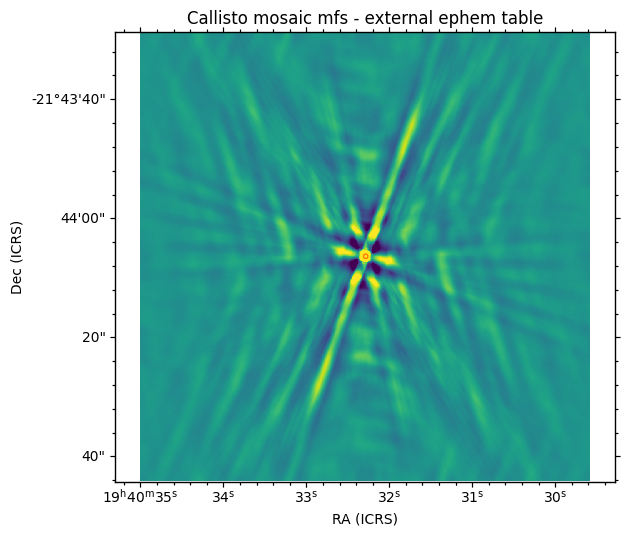

In [27]:
displayImage(imgname+'.image', markers=markers, 
             title='Callisto mosaic mfs - external ephem table')

As expected, the center of the image and the position from the external ephemeris table at the time recorded in the image header agree and the the source appears at the center of the image.

In [28]:
print("external ephem dir = ",qa.time(exteph_dir['m0'],prec=9),qa.angle(exteph_dir['m1'],prec=9))
printImageCenter(imgname+'.image')

external ephem dir =  ['19:40:32.284'] ['-021.44.06.375']


('19:40:32.284', '-021.44.06.375')

In [29]:
from casatasks import imstat
stats= imstat(imgname+'.image')
print(f"peak : {stats['max'][0]} at {stats['maxpos'][0]}")

peak : 0.010875074192881584 at 540
